In [81]:
import os
import yaml
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.patches import Patch
from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay
import sklearn.metrics as metrics
from typing import cast, Tuple

from ba_dev.utils import load_path_yaml
from ba_dev.eval_helpers import *

paths = load_path_yaml('../../data/path_config.yml')

set_custom_plot_style()
cm = 1 / 2.54

export = True

### Balanced Accuracy of all Models

In [7]:
# # calculating the balanced accuracy score for all runs
# bal_acc = evaluate_all_runs(
#     path_to_runs=paths['complete_models'],
#     metrics='balanced_accuracy_score',
#     )

# bal_acc.to_csv('bal_acc.csv', index=False)

bal_acc = pd.read_csv('bal_acc.csv')

In [78]:
def place_table(
        latex_table: str,
        center: bool = True,
        placement: str | None = None,
        ) -> str:

    lines = latex_table.splitlines()

    if placement:
        lines[0] = f'\\begin{{table}}[{placement}]'

    if center:
        lines.insert(1, r'\centering')

    return '\n'.join(lines)

In [82]:
# Balanced accuracy Table for all models
########################################################################################################################
table_name = 'bal_acc_by_model'
caption = r'Balanced accuracy of all models -- shown as mean ± standard deviation.'
########################################################################################################################

summary_bal_acc = (
    bal_acc
    .groupby(['model_name', 'pretrained'])
    .agg(
        trainable_params=('trainable_params', 'first'),
        img_score_mean=('img_score', 'mean'),
        img_score_std =('img_score', 'std'),
        seq_score_mean=('seq_score', 'mean'),
        seq_score_std =('seq_score', 'std'),
    )
    .reset_index()
    .sort_values(
        by=['pretrained', 'trainable_params'],
        ascending=[False, True]
    )
    )

for scope in ['img', 'seq']:
    mean_str = summary_bal_acc[f'{scope}_score_mean'].map("{:.4f}".format)
    std_str  = summary_bal_acc[f'{scope}_score_std'].map("{:.3f}".format)
    summary_bal_acc[f'bal_acc_{scope}'] = mean_str + ' ± ' + std_str

table = (
        summary_bal_acc[
            ['model_name', 'pretrained', 'trainable_params', 'bal_acc_img', 'bal_acc_seq']
        ]
        .rename(columns={
            'model_name': 'Model',
            'pretrained': 'Pretrained',
            'trainable_params': 'Params (M)',
            'bal_acc_img': r'Image BA-Score',
            'bal_acc_seq': r'Sequence BA-Score'
        }))

table['Params (M)'] = (table['Params (M)'] / 1_000_000).astype(int)
table['Pretrained'] = table['Pretrained'].map({True: 'Yes', False: 'No'})

latex = table.to_latex(
    index=False,
    column_format='l c r c c',
    escape=True,
    caption=caption,
    label=f'tab:{table_name}',
    )

lines = latex.splitlines()

for i, line in enumerate(lines):
    if '& No &' in line:
        split_index = i
        break

new_lines = lines[:split_index] + ['\midrule'] + lines[split_index:]

latex = "\n".join(new_lines)

latex = place_table(latex, center=True, placement='H')

print(latex)

if export:
    with open(paths['table'] / f'{table_name}.tex', 'w') as f:
        f.write(latex)


\begin{table}[H]
\centering
\caption{Balanced accuracy of all models -- shown as mean ± standard deviation.}
\label{tab:bal_acc_by_model}
\begin{tabular}{l c r c c}
\toprule
Model & Pretrained & Params (M) & Image BA-Score & Sequence BA-Score \\
\midrule
efficientnet\_b0 & Yes & 4 & 0.9921 ± 0.004 & 0.9947 ± 0.002 \\
densenet169 & Yes & 12 & 0.9904 ± 0.004 & 0.9939 ± 0.002 \\
resnet50 & Yes & 23 & 0.9899 ± 0.004 & 0.9934 ± 0.002 \\
vit\_b\_16 & Yes & 85 & 0.9885 ± 0.005 & 0.9933 ± 0.002 \\
\midrule
efficientnet\_b0 & No & 4 & 0.9856 ± 0.005 & 0.9898 ± 0.003 \\
densenet169 & No & 12 & 0.9863 ± 0.006 & 0.9899 ± 0.002 \\
resnet50 & No & 23 & 0.9850 ± 0.004 & 0.9888 ± 0.003 \\
vit\_b\_16 & No & 85 & 0.9767 ± 0.006 & 0.9856 ± 0.004 \\
\bottomrule
\end{tabular}
\end{table}


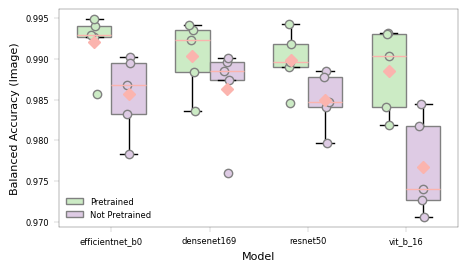

In [ ]:
# Box Plot for Balanced Accuracy by Model and Pretrained Status
########################################################################################################################
fig_name = 'bal_acc_img.pdf'
fig_size = (12*cm,7*cm)
########################################################################################################################

models = ['efficientnet_b0', 'densenet169','resnet50', 'vit_b_16']
n = len(models)
x = range(n)
width = 0.35

# collect your two series
data_pre = [
    bal_acc[(bal_acc['model_name']==m) & (bal_acc['pretrained'])]['img_score'] 
    for m in models
]
data_no = [
    bal_acc[(bal_acc['model_name']==m) & (~bal_acc['pretrained'])]['img_score'] 
    for m in models
]

cmap = plt.get_cmap('Pastel1')
color_pre = cmap(2)
color_no  = cmap(3)
red = cmap(0)

plt.figure(figsize=fig_size)

medianprops = dict(linewidth=1, color=red)

meanprops = dict(
                marker='D',
                markeredgecolor=red,
                markerfacecolor=red,
                markersize=6
                )

flierprops = dict(marker='', linestyle='none')

# draw the boxplots
bp_pre = plt.boxplot(
    data_pre,
    positions=[i - width/2 for i in x],
    widths=width,
    patch_artist=True,
    manage_ticks=False,
    showmeans=True,
    meanprops=meanprops,
    medianprops=medianprops,
    flierprops=flierprops
)
bp_no = plt.boxplot(
    data_no,
    positions=[i + width/2 for i in x],
    widths=width,
    patch_artist=True,
    manage_ticks=False,
    showmeans=True,
    meanprops=meanprops,
    medianprops=medianprops,
    flierprops=flierprops
)

# apply facecolors and a subtle edge
for box in bp_pre['boxes']:
    box.set_facecolor(color_pre)
    box.set_edgecolor('gray')
for box in bp_no['boxes']:
    box.set_facecolor(color_no)
    box.set_edgecolor('gray')

# axes labels
plt.xticks(x, models, ha='center')
plt.xlabel('Model')
plt.ylabel('Balanced Accuracy (Image)')

# legend with box patches!
legend_handles = [
    Patch(facecolor=color_pre, edgecolor='gray', label='Pretrained'),
    Patch(facecolor=color_no,  edgecolor='gray', label='Not Pretrained')
]
plt.legend(handles=legend_handles, frameon=False, loc='lower left')

for i, m in enumerate(models):
    # pretrained points
    y_pre = bal_acc[(bal_acc['model_name']==m) & (bal_acc['pretrained'])]['img_score']
    x_pre = np.random.normal(i - width/2, width*0.05, size=len(y_pre))
    plt.scatter(x_pre, y_pre, color=color_pre, edgecolor='gray', zorder=2)

    # non-pretrained points
    y_no  = bal_acc[(bal_acc['model_name']==m) & (~bal_acc['pretrained'])]['img_score']
    x_no  = np.random.normal(i + width/2, width*0.05, size=len(y_no))
    plt.scatter(x_no, y_no, color=color_no,  edgecolor='gray', zorder=2)


plt.tight_layout()

if export:
    plt.savefig(paths['figures'] / fig_name, dpi=300)
plt.show()

In [87]:
models

['densenet169', 'efficientnet_b0', 'resnet50', 'vit_b_16']

### Performance of Best Model

In [10]:
summary = (
    bal_acc
    .groupby(['model_name', 'pretrained'])
    .agg(
        experiment_name=('experiment_name', 'first'),
        img_score_mean=('img_score', 'mean'),
    )
    .reset_index()
    )

best_row = summary.loc[summary['img_score_mean'].idxmax()]

best_experiment_path = paths['complete_models'] / str(best_row['experiment_name'])

best_model = LoadRun(
    log_path=best_experiment_path
)

all_testsets = pd.DataFrame()

for fold in range(5):
    new_data = best_model.get_predictions(
        set_selection='test',
        fold=fold
        )
    
    new_data['fold'] = fold
    
    all_testsets = pd.concat([all_testsets, new_data], ignore_index=True)

y_true = all_testsets['class_id'].to_list()
y_pred = all_testsets['pred_id'].to_list()


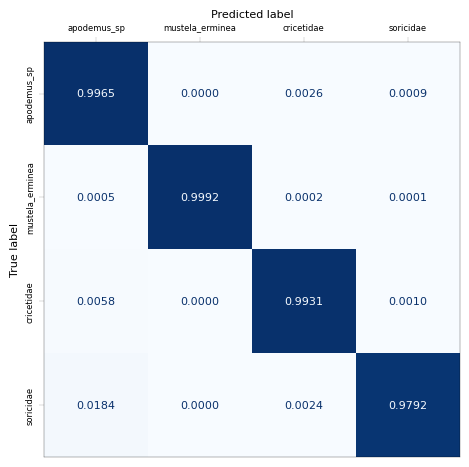

In [45]:
# Confusion Matrix for the best model
########################################################################################################################
fig_name = 'conf_matrix_best.pdf'
fig_size = (12*cm,12*cm)
########################################################################################################################

labels = list(best_model.decoder.values())

confusion_matrix = metrics.confusion_matrix(
    y_true,
    y_pred,
    labels=list(best_model.decoder.keys()),
    normalize='true'
)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                              display_labels=labels)
fig, ax = plt.subplots(figsize=fig_size)
disp.plot(
    ax=ax,
    cmap='Blues',
    colorbar=False,
    values_format='.4f'
)

n = len(labels)
ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(n))
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.xticks(rotation=0, ha='center')
plt.yticks(rotation=90, va='center')

plt.tight_layout()
if export:
        plt.savefig(paths['figures'] / fig_name, dpi=300)
plt.show()

In [90]:
# Precision, Recall and F1-Score for the best model
########################################################################################################################
table_name = 'precision_recall_fscore_support'
caption = r'Class-wise precision, recall, F1-score, and support for the best-performing model.'
########################################################################################################################

labels_ids = [k for k in best_model.decoder]

result  = metrics.precision_recall_fscore_support(
    y_true,
    y_pred,
    labels=list(best_model.decoder.keys()),
    zero_division=0
)

precision, recall, f1_score, support = cast(
    Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray],
    result
)

data = []
for i, label in enumerate(list(best_model.decoder.values())):
    data.append({
        'Class'    : label,
        'Precision': precision[i],
        'Recall'   : recall[i],
        'F1-Score' : f1_score[i],
        'Support'  : int(support[i]),
    })

df = pd.DataFrame(data)

latex = df.to_latex(
    index=False,
    column_format='l r r r r',
    escape=True,
    float_format="%.3f",
    caption=caption,
    label=f'tab:{table_name}',
    )

latex = place_table(latex, center=True, placement='H')

print(latex)

if export:
    with open(paths['table'] / f'{table_name}.tex', 'w') as f:
        f.write(latex)


\begin{table}[H]
\centering
\caption{Class-wise precision, recall, F1-score, and support for the best-performing model.}
\label{tab:precision_recall_fscore_support}
\begin{tabular}{l r r r r}
\toprule
Class & Precision & Recall & F1-Score & Support \\
\midrule
apodemus\_sp & 0.996 & 0.997 & 0.996 & 260075 \\
mustela\_erminea & 0.999 & 0.999 & 0.999 & 13175 \\
cricetidae & 0.995 & 0.993 & 0.994 & 144402 \\
soricidae & 0.971 & 0.979 & 0.975 & 12780 \\
\bottomrule
\end{tabular}
\end{table}
